In [2]:


import numpy as np

from pydtmc import MarkovChain
from pydtmc import plot_graph
from pydtmc import plot_eigenvalues
from pydtmc import plot_walk

import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
def get_sorted_vocab(words): return sorted(np.unique(words))

In [70]:

    
def get_encoding(words): 
    vocabulary_sorted = get_sorted_vocab(words)
    rank = 0
    vocabulary_code = {}
    for word in vocabulary_sorted:
        vocabulary_code[word] = rank
        rank+=1
    return vocabulary_code

# function to return key for any value

def _get_key(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
            return key
    return "key not found"

def encode(words, vocabulary_code):
    return list(map(lambda w: vocabulary_code.get(w), words))

def decode(codes, encoding):
    return list(map(lambda w: _get_key(w, encoding), codes))



DISCRETE-TIME MARKOV CHAIN
 SIZE:           4
 RANK:           3
 CLASSES:        3
  > RECURRENT:   1
  > TRANSIENT:   2
 ERGODIC:        NO
  > APERIODIC:   NO (2)
  > IRREDUCIBLE: NO
 ABSORBING:      NO
 REGULAR:        NO
 REVERSIBLE:     NO
 SYMMETRIC:      NO



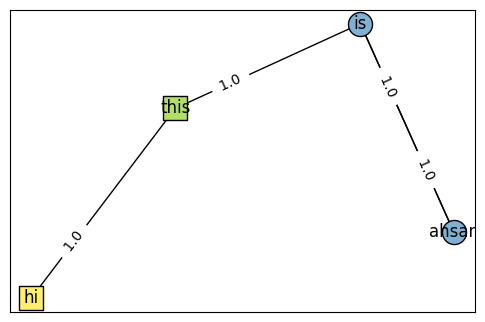

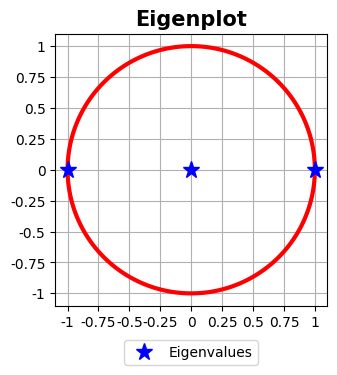

['is', 'ahsan', 'is', 'ahsan', 'is']

In [71]:
# Read text
text = 'hi this is ahsan is'

# Text Transformation (Tokenization and encoding)

words = text.split()
encoding = get_encoding(words)
words_encoded = encode(words, encoding)

# Build markov chain

p = transition_matrix(words_encoded)
mc = MarkovChain(p, get_sorted_vocab(words))
print(mc)
plot_graph(mc)
plot_eigenvalues(mc)

# Start random walk of x given steps in markov chain starting from given word

mc.walk(5)
# print(words_encoded)

# print(decode(words_encoded, encoding))

In [62]:
#the following code takes a list such as
#[1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
#with states labeled as successive integers starting with 0
#and returns a transition matrix, M,
#where M[i][j] is the probability of transitioning from i to j

def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

#test:



DISCRETE-TIME MARKOV CHAIN
 SIZE:           4
 RANK:           4
 CLASSES:        2
  > RECURRENT:   1
  > TRANSIENT:   1
 ERGODIC:        NO
  > APERIODIC:   YES
  > IRREDUCIBLE: NO
 ABSORBING:      YES
 REGULAR:        NO
 REVERSIBLE:     NO
 SYMMETRIC:      NO



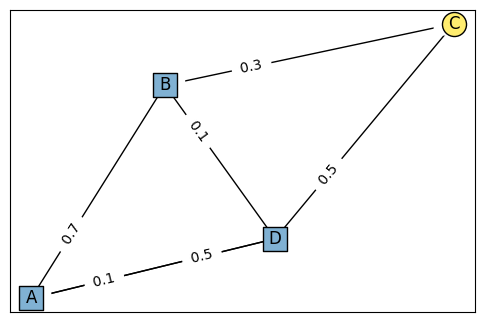

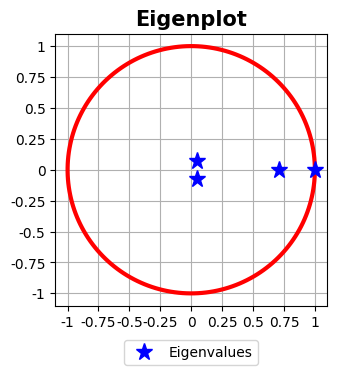

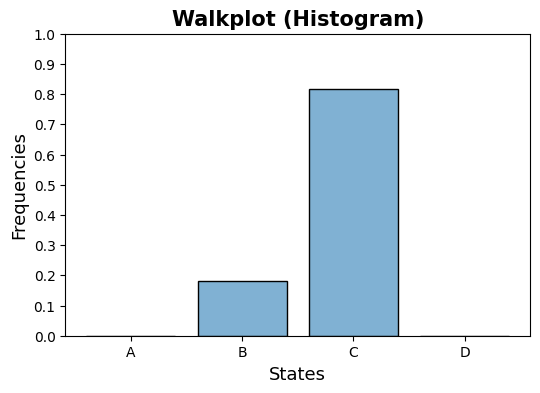

['B', 'D', 'A', 'B', 'C']

In [59]:
p = [[0.2, 0.7, 0.0, 0.1], [0.0, 0.6, 0.3, 0.1], [0.0, 0.0, 1.0, 0.0], [0.5, 0.0, 0.5, 0.0]]
mc = MarkovChain(p, ['A', 'B', 'C', 'D'])
print(mc)
plot_graph(mc)
plot_eigenvalues(mc)
plot_walk(mc, 10, 'B')
mc.walk(5)

In [ ]:
# !pip3 install pydot
# !pip3 install PyDTMC